In [2]:
import sys
sys.path.append('../..')
import numpy as np
import matplotlib.pyplot as plt

# PyTorch
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch import cuda
from torch.autograd import Variable
from torchvision.utils import make_grid
from torchvision.models.mobilenet import mobilenet_v2

# DLBio and own scripts
from DLBio.pytorch_helpers import get_device
import ds_ear_siamese
import transforms_data as td
from helpers import cuda_conv
from metrics import conf_matrix_elements
from siamese_network_train import Training
from ContrastiveLossFunction import ContrastiveLoss
from NN_Siamese import SiameseNetwork

In [2]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,value1, val_iteration, value2, label1, label2, plt_number):
    plt.figure(plt_number)
    plt.plot(iteration,value1, label=label1)
    plt.plot(val_iteration,value2, label=label2)
    plt.legend()
    plt.grid()

In [3]:
# Set Up All Configurations here
class Config():
    NN_SIAMESE = False
    dataset_dir = '../AMIC/'conf_matrix_elements
    # training_dir = "../data/ears/training/"
    # testing_dir = "../data/ears/testing/"
    train_batch_size = 32
    val_batch_size = 32
    test_batch_size = 1
    vis_batch_size = 8
    num_workers = 3
    
    EPOCHS= 50
    LEARNINGRATE = 0.001
    WEIGHT_DECAY = 1

    TRESHOLD_VER = 0.8
    a = 0

In [4]:
# define indicies to split Data
N = len(ds_ear_siamese.get_dataset(data_path=Config.dataset_dir, transform_mode='size_only'))
print(N)
n_80 = int(round(.8*N))
n_70 = int(round(.7*N))
n_60 = int(round(.6*N))
n_20 = int(round(.2*N))
n_10 = int(round(.1*N))

rand_indices = np.random.permutation(N)
train_indices = rand_indices[:n_70]
val_indices = rand_indices[n_70:n_70+n_20]
test_indices = rand_indices[n_70+n_20:]


# definde data loader
# dl_train = ds_ear_siamese.get_dataloader(
train_dataloader = ds_ear_siamese.get_dataloader(
    data_path=Config.dataset_dir,
    indices=train_indices,
    batch_size=Config.train_batch_size,
    num_workers=Config.num_workers,
    transform_mode='siamese', # TODO switch to another transform?
    should_invert = False
)

val_dataloader = ds_ear_siamese.get_dataloader(
    data_path=Config.dataset_dir,
    indices=val_indices,
    batch_size=Config.val_batch_size,
    num_workers=Config.num_workers,
    transform_mode='siamese_valid_and_test',
    should_invert = False
)
# dl_test = ds_ear_siamese.get_dataloader(
test_dataloader = ds_ear_siamese.get_dataloader(
    data_path=Config.dataset_dir,
    indices=test_indices,
    batch_size=Config.test_batch_size,
    num_workers=Config.num_workers,
    transform_mode='siamese_valid_and_test',
    should_invert = False
)

vis_dataloader = ds_ear_siamese.get_dataloader(
    data_path=Config.dataset_dir,
    indices=train_indices,
    batch_size=Config.vis_batch_size,
    num_workers=Config.num_workers,
    transform_mode='siamese',
    should_invert = False
)

['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034', '035', '036', '037', '038', '039', '040', '041', '042', '043', '044', '045', '046', '047', '048', '049', '050', '051', '052', '053', '054', '055', '056', '057', '058', '059', '060', '061', '062', '063', '064', '065', '066', '067', '068', '069', '070', '071', '072', '073', '074', '075', '076', '077', '078', '079', '080', '081', '082', '083', '084', '085', '086', '087', '088', '089', '090', '091', '092', '093', '094', '095', '096', '097', '098', '099', '100']
700


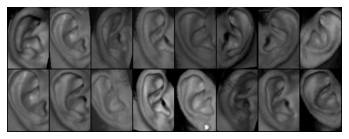

[[1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]]


In [5]:
# visualize some data....
dataiter = iter(vis_dataloader)

example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0], example_batch[1]),0)
imshow(make_grid(concatenated))
print(example_batch[2].numpy())

In [6]:
# Definde Model and load to device
if Config.NN_SIAMESE == False:
    model = mobilenet_v2(pretrained=True)
    model.features[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    #model.classifier[1] = nn.Linear(in_features=model.classifier[1].in_features, out_features=10)
    
    layers = []
    for layer in model.features[0]:
        layers.append(layer)
    model.features[0][0] = nn.ReflectionPad2d(1)
    model.features[0][1] = layers[0]
    model.features[0][2] = layers[1]
    model.features[0].add_module('3', layers[2])
    
    model.classifier = nn.Sequential(*list(model.classifier.children())[:-2])
    
    #model = torch.nn.Sequential(*(list(model.children())[:-1]))
    #model = model.features

else:
    model = SiameseNetwork()


device = get_device()
print(device)
model.to(device)

contrastive_loss_siamese = ContrastiveLoss(2.0)
optimizer_siamese = torch.optim.Adam(model.parameters(),lr = Config.LEARNINGRATE)

cuda:0


In [ ]:
# To Define which Layers we want to train
# for param in model.parameters():
#     param.requires_grad = False

# layers = list(model.children())[0]
# sub_layer = list(layers.children())
# unfreezed = [1,14,15, 16, 17, 18]
# for u in unfreezed:
#     for param in sub_layer[u].parameters():
#         param.requires_grad = True

In [7]:
# To show trainable parameters
from DLBio.pytorch_helpers import get_num_params

get_num_params(model,True)

2223296

In [8]:
training = Training(model=model, optimizer=optimizer_siamese,train_dataloader=train_dataloader, val_dataloader=val_dataloader, loss_contrastive=contrastive_loss_siamese, nn_Siamese=Config.NN_SIAMESE, THRESHOLD=Config.TRESHOLD_VER)

counter, loss_history, val_counter, val_loss_history, acc_history, val_acc_history = training(Config.EPOCHS)
show_plot(counter, loss_history,val_counter, val_loss_history,'train_loss', 'val_loss',1)
show_plot(counter, acc_history,val_counter, val_acc_history,'train_acc', 'val_acc', 2)

Epoch number 0
 Current loss 261.2633
 Current acc 59.38

Epoch number 0
 Current loss 4.6777
 Current acc 43.75

Epoch number 0
 Current val_loss 0.7040
 Current val_acc 65.62

Epoch number 1
 Current loss 1.0094
 Current acc 68.75

Epoch number 1
 Current loss 1.1395
 Current acc 46.88

Epoch number 1
 Current val_loss 0.7540
 Current val_acc 65.62

Epoch number 2
 Current loss 0.9678
 Current acc 50.00

Epoch number 2
 Current loss 1.0719
 Current acc 53.12

Epoch number 2
 Current val_loss 0.9220
 Current val_acc 56.25

Epoch number 3
 Current loss 1.1977
 Current acc 46.88



KeyboardInterrupt: 

In [9]:
if Config.NN_SIAMESE:
    def generate_output(img_in, img_in2):
        return model(
                cuda_conv(Variable(img_in)),
                cuda_conv(Variable(img_in2))
                )
else:
    def generate_output(img_in):
        return model(
                cuda_conv(Variable(img_in))
                )   

In [ ]:
# Evaluate the Test set
tn_all, fp_all, fn_all, tp_all = 0, 0, 0, 0

for i, data in enumerate(test_dataloader):
    # use training class for data extraction
    label, output1, output2 = training.get_label_outputs(data)
    # get the elements for a confusion matrix
    tn, fp, fn, tp = conf_matrix_elements(img0, img1)
    tn_all += tn
    fp_all += fp
    fn_all += fn
    tp_all += tp


In [11]:
iter_batches = iter(test_dataloader)
accuracy_count = 0.0
matches = []
non_matches = []
for i in range(len(iter_batches)):
    # batch size schould be 1 to throw no errors in accessing the next(iter_batches) 
    img0, img1, label = next(iter_batches)
    # appends images to matches, if label is 0 (0 = same)
    ((matches, non_matches)[int(label)]).append( (img0,img1) )

# iterate through both lists and compare the distances of the current entries
for m, n in zip(matches, non_matches):
    # get the models output vectors for the images
    
    if Config.NN_SIAMESE:
        match_out1, match_out2 = generate_output(m[0], m[1])
        non_match_out1, non_match_out2 = generate_output(n[0], n[1])
    else:
        match_out1 = generate_output(m[0])
        match_out2 = generate_output(m[1])                 
        non_match_out1 = generate_output(n[0])
        non_match_out2 = generate_output(n[1])
        
    # positive-positive, positive-negative distance
    euclidean_distance_pp = F.pairwise_distance(match_out1, match_out2)
    #euclidean_distance_pn = F.pairwise_distance(non_match_out1, non_match_out2)
    
    # format variables
    fmt_id = '{:<12}'
    fmt_eucl = '{:<.3f}'
    # increase accouracy count if p-p was lower than p-n
    if(euclidean_distance_pp < Config.TRESHOLD_VER): accuracy_count += 1
    # print current stats
    print(fmt_id.format('pos-pos: '), fmt_eucl.format( euclidean_distance_pp.item()) )
    # print(fmt_id.format('pos-neg: '),fmt_eucl.format( euclidean_distance_pn.item()) )
    print(fmt_id.format('Acc. count: '), '{:>.0f}'.format(accuracy_count), '\n')

# divide by the minimum length (zip function regulated the steps to the minimum)
print(fmt_id.format('Overall (estimated) accuracy: '), fmt_eucl.format( 100 * accuracy_count / min(len(matches), len(non_matches)) ), ' %')

pos-pos:     0.000
Acc. count:  1 

pos-pos:     0.000
Acc. count:  2 

pos-pos:     0.127
Acc. count:  3 

pos-pos:     0.193
Acc. count:  4 

pos-pos:     0.131
Acc. count:  5 

pos-pos:     0.000
Acc. count:  6 

pos-pos:     0.135
Acc. count:  7 

pos-pos:     0.000
Acc. count:  8 

pos-pos:     0.000
Acc. count:  9 

pos-pos:     0.000
Acc. count:  10 

pos-pos:     0.195
Acc. count:  11 

pos-pos:     0.000
Acc. count:  12 

pos-pos:     0.000
Acc. count:  13 

pos-pos:     0.000
Acc. count:  14 

pos-pos:     0.000
Acc. count:  15 

pos-pos:     0.092
Acc. count:  16 

pos-pos:     0.000
Acc. count:  17 

pos-pos:     0.069
Acc. count:  18 

pos-pos:     0.000
Acc. count:  19 

pos-pos:     0.000
Acc. count:  20 

pos-pos:     0.000
Acc. count:  21 

pos-pos:     0.000
Acc. count:  22 

pos-pos:     0.000
Acc. count:  23 

pos-pos:     0.000
Acc. count:  24 

pos-pos:     0.000
Acc. count:  25 

pos-pos:     0.000
Acc. count:  26 

Overall (estimated) accuracy:  100.000  %


In [ ]:
#model = torch.load('/Users/falcolentzsch/Develope/Bachelorthesis/Bachelorthesis/models/model.pt')

In [ ]:
#torch.save(model,'/nfshome/lentzsch/Documents/Bachelorarbeit/Bachelorthesis/models/model_MN_1.pt')